### Introducción 

El Mantenimiento Predictivo es una estrategia proactiva que emplea análisis de datos, sensores y algoritmos de aprendizaje automático para anticipar posibles fallos, permitiendo intervenciones precisas y oportunas. Esta metodología ofrece ventajas significativas, especialmente en eficiencia de costos al minimizar períodos de inactividad y prevenir paradas imprevistas. 

Por otro lado, los actuadores electromecánicos (EMA) juegan un papel fundamental en la industria, particularmente en robots de líneas de ensamblaje. Estos dispositivos ofrecen un control preciso sobre el movimiento, una característica esencial en entornos donde la calidad y la precisión son críticas. En comparación con sistemas hidráulicos, los EMA destacan por su eficiencia energética y requerimientos de mantenimiento reducidos, fomentando la implementación de prácticas industriales sostenibles y la reducción de costos operativos.

En este contexto, reconocer la vida útil de un actuador electromecánico se vuelve crucial porque contribuye directamente al rendimiento optimo del equipo donde el actuador hace parte. Una falla catastrófica en uno de los actuadores de un robot de ensamblaje puede llevar a una perdida total o parcial de la funcionalidad del robot, podria dañar componentes adyacentes al robot, llevar a una interrupción completa de la linea de producción y en el peor de los casos comprometer la seguridad personal de algun trabajador. 

#### Repositorio : 

Los datos se colectan de un banco de pruebas que supervisa actuadores electromecánicos (EMA). Consiste en 19 conjuntos de datos que representan diferentes perfiles de movimiento y carga a diferentes fallas del EMA (EMAs con diferentes modos de falla preinstalados). Los datos recolectados a una frecuencia de muestreo de 1kHz incluyen voltajes, corrientes y temperaturas, mientras que los datos a 20 kHz contienen señales de vibración capturadas por acelerómetros.

El objetivo principal era desarrollar sistemas de pronóstico para EMAs, especialmente en la aviación. Los EMAs ofrecen ventajas cruciales en aviación, y estos datos permiten crear modelos precisos para anticipar y mitigar fallas potenciales. Este enfoque proactivo mejora la seguridad y eficiencia operativa en la industria aeronáutica.

La base de datos utilizada proviene del repositorio: https://c3.ndc.nasa.gov/dashlink/  del NASA AMES Center que proporciona bases de datos de libre uso. 


#### Datos Utilizados: 

De los diferentes perfiles de falla se optó por el "ballscrew jam fault" (Atasco del huesillo  de bolas) porque es una de las fallas mas catastróficas y que puede mostrar signos severos de alerta en los datos de temperatura, corriente o vibración debido a que genera fuerzas y tensiones inesperadas que pueden conducir a la perdida de movilidad o a la limitación severa del actuador. 

Finalmente, se optó por la temperatura como variable de análisis debido a la existencia de un umbral reconocido en la literatura, estableciéndose en 40°C para los motores de actuadores. Superar este límite implica la necesidad de realizar mantenimiento en el actuador. Pronosticar el comportamiento de esta variable se vuelve crítico, ya que conocer la Vida Útil Restante (RUL, por sus siglas en inglés) del actuador depende directamente de la anticipación y comprensión de la evolución de la temperatura en los motores del actuador. 

| Estampa de tiempo <br>Cada 10 milisegundos <br>desde: |  <br>Temperatura  |
|---|---|
| 2010-09-06 16:54:19 | Celsius |

In [1]:
!pip install darts

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/aa/b4/a78d92e8edf785d6155e53b0bdd139cd918eb83215d80eb2070d24b01f49/darts-0.27.0-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/48.4 kB ? eta -:--:--
     -------------------------------------- 48.4/48.4 kB 811.7 kB/s eta 0:00:00
  Obtaining dependency information for holidays>=0.11.1 from https://files.pythonhosted.org/packages/69/ab/1a5589bc09f933b1ee68e49849af78f892dec4459278885a5fb2b06c1a3a/holidays-0.38-py3-none-any.whl.metadata
  Using cached nfoursid-1.0.1-py3-none-any.whl (16 kB)
  Obtaining dependency information for pmdarima>=1.8.0 from https://files.pythonhosted.org/packages/fe/a4/79d694daa45b86df0c87d17a16632c8f1f65e6bef84f1e4c6be5a24be38e/pmdarima-2.0.4-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/160.5 kB ? eta -:--:--
     -------------------------------------- 160.5/160.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.25.1 which is incompatible.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.25.1 which is incompatible.


In [2]:
%pip install darts


import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import numpy as np
import matplotlib.dates as mdates

from scipy.fft import fft
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from darts.models import ExponentialSmoothing, MovingAverageFilter
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import mape, mse
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.utils.statistics import extract_trend_and_seasonality, plot_acf, plot_pacf



Note: you may need to restart the kernel to use updated packages.


c:\Users\lasom\anaconda3\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [84]:
import pandas as pd

# Lectura del Dataset 
column_names_low_Frequency = ['Time', 'Desired_Position', 'Actuator_X_Position', 'Actuator_Y_Position', 'Actuator_Z_Position',
                'Desired_Load', 'Measured_Load', 'Motor_X_Current', 'Motor_Y_Current', 'Motor_Z_Current',
                'Motor_X_Voltage', 'Motor_Y_Voltage', 'Motor_Z_Voltage', 'Motor_X_Temperature', 'Motor_Y_Temperature',
                'Motor_Z_Temperature', 'Nut_X_Temperature', 'Nut_Y_Temperature', 'Nut_Z_Temperature', 'Ambient_Temperature']


# Use double backslashes or a raw string for the file path
dir_data = r"C:\Users\lasom\OneDrive\Desktop\Folder\Maestria\Series de Tiempo\Trabajo_Final\2010_09_06_2\2010_09_06\sdata\BatchProfile_sine13_2010_09_06_16_54_18_Jam_Low.data"

# Read the dataset with tab-separated values
df = pd.read_csv(dir_data, names=column_names_low_Frequency, sep='\t', header=None)

# # Print the split result to understand the structure
# split_result = df['Time'].str.split('_', expand=True)
# print(split_result)

df[['Timestamp', 'Hour', 'Timezone']] = df['Time'].str.split('_', expand=True)

# df['Hour'] = pd.to_datetime(df['Hour'], format='%H:%M:%S.%f', errors='coerce')

fixed_date = '2010-09-06 '
df['Hour'] = pd.to_datetime(fixed_date + df['Hour'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')


df.set_index('Hour', inplace=True)

df.head()




,Time,Desired_Position,Actuator_X_Position,Actuator_Y_Position,Actuator_Z_Position,Desired_Load,Measured_Load,Motor_X_Current,Motor_Y_Current,Motor_Z_Current,...,Motor_Z_Voltage,Motor_X_Temperature,Motor_Y_Temperature,Motor_Z_Temperature,Nut_X_Temperature,Nut_Y_Temperature,Nut_Z_Temperature,Ambient_Temperature,Timestamp,Timezone
Hour,,,,,,,,,,,,,,,,,,,,,
2010-09-06 16:54:19.000,2010-09-06_16:54:19.00000_-0700,NaN,NaN,NaN,46.551188,NaN,16.805925,-0.174810,0.372113,0.382564,...,NaN,23.554150,26.632777,26.239193,33.817814,28.439102,NaN,24.773844,2010-09-06,-0700
2010-09-06 16:54:19.010,2010-09-06_16:54:19.01000_-0700,NaN,NaN,NaN,46.682504,NaN,15.351957,-0.759180,0.440914,0.353824,...,NaN,23.864380,26.547675,26.232778,34.276418,29.137700,NaN,24.770623,2010-09-06,-0700
2010-09-06 16:54:19.020,2010-09-06_16:54:19.02000_-0700,NaN,NaN,NaN,47.087099,NaN,15.982924,-1.671877,0.382564,0.338148,...,NaN,23.633339,26.317936,26.002887,35.906463,28.360707,NaN,24.773844,2010-09-06,-0700
2010-09-06 16:54:19.030,2010-09-06_16:54:19.03000_-0700,NaN,NaN,NaN,47.466851,NaN,16.229825,-3.184617,0.351211,0.395627,...,NaN,23.718965,25.615206,26.324351,34.443908,28.131837,NaN,24.773844,2010-09-06,-0700
2010-09-06 16:54:19.040,2010-09-06_16:54:19.04000_-0700,NaN,NaN,NaN,47.686894,NaN,15.297090,-2.361624,0.338148,0.396498,...,NaN,23.243716,25.694052,26.403079,33.824129,29.619857,NaN,24.770623,2010-09-06,-0700


                         Nut_X_Temperature
Hour                                      
2010-09-06 16:54:19.000          33.817814
2010-09-06 16:54:19.010          34.276418
2010-09-06 16:54:19.020          35.906463
2010-09-06 16:54:19.030          34.443908
2010-09-06 16:54:19.040          33.824129
...                                    ...
2010-09-06 16:54:48.650          34.366479
2010-09-06 16:54:48.660          34.598731
2010-09-06 16:54:48.670          34.759808
2010-09-06 16:54:48.680          34.289037
2010-09-06 16:54:48.690          34.756656

[2970 rows x 1 columns]


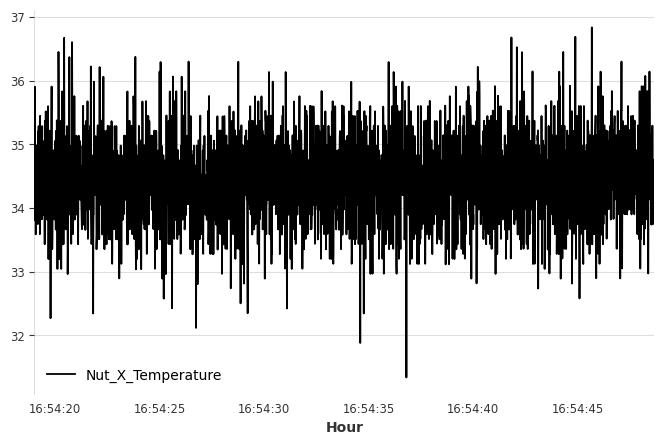

In [85]:
df_nut_temp = df[['Nut_X_Temperature']]
df_nut_temp.plot(figsize=(8,5))

print(df_nut_temp)

<Axes: xlabel='Hour'>

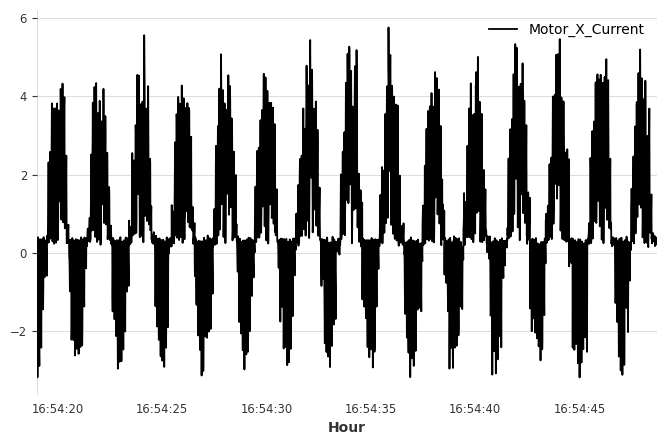

In [93]:
df_nut_cur= df[['Motor_X_Current']]
df_nut_cur.plot(figsize=(8,5))

### Transformaciones

Tranformacion para la temperatura en el cojinete 

<Axes: xlabel='Hour'>

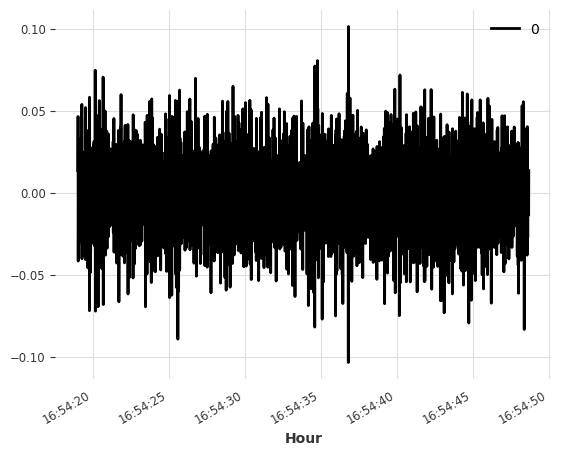

In [109]:
series_nut_temp = TimeSeries.from_dataframe(df_nut_temp)

# Transformaciones
log_nut_temp = np.log(series_nut_temp.values())
log_series_nut_temp = TimeSeries.from_times_and_values(series_nut_temp.time_index, log_nut_temp ) 
log_series_nut_temp_diff = log_series_nut_temp.diff()

log_series_nut_temp_diff.plot()

Transformacion de la corriente en el motor

C:\Users\lasom\AppData\Local\Temp\ipykernel_4088\3435833694.py:4: RuntimeWarning: invalid value encountered in log
  log_motor_cur = np.log(series_motor_cur.values())


<Axes: xlabel='Hour'>

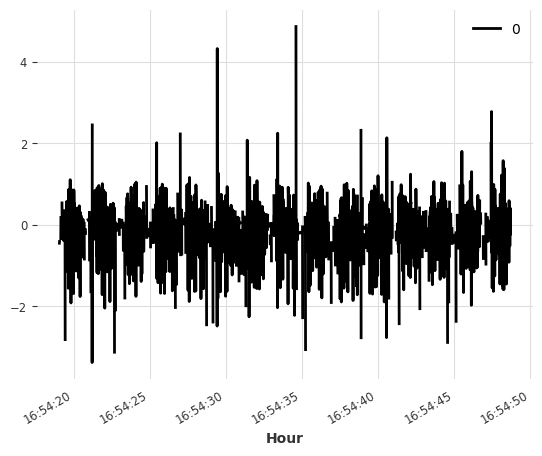

In [110]:
series_motor_cur = TimeSeries.from_dataframe(df_nut_cur)

# Transformaciones
log_motor_cur = np.log(series_motor_cur.values())
log_series_motor_cur = TimeSeries.from_times_and_values(series_motor_cur.time_index, log_motor_cur ) 
log_series_motor_cur_diff = log_series_motor_cur.diff()

log_series_motor_cur_diff.plot()

### ACF y PACF sin transformar 

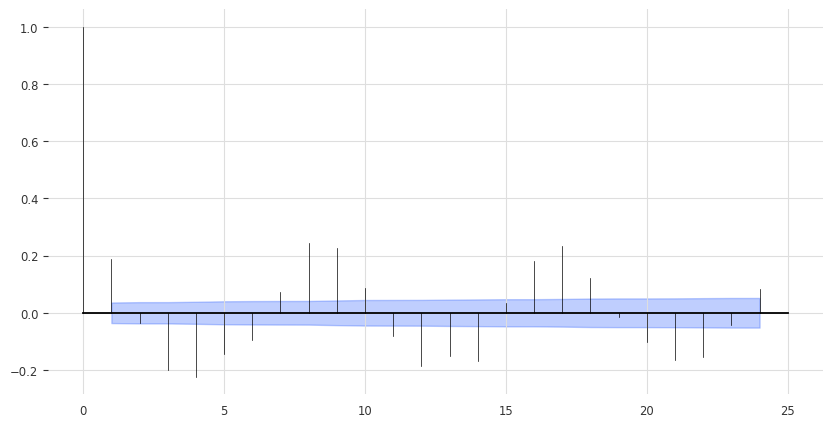

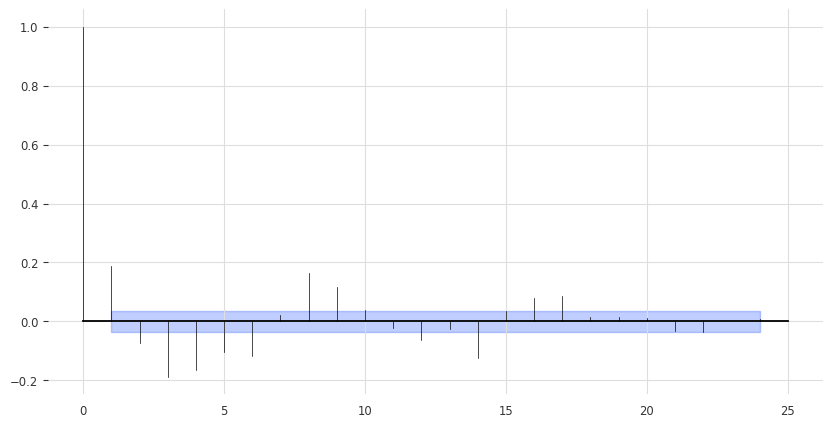

In [111]:
plot_acf(series_nut_temp)
plot_pacf(series_nut_temp)

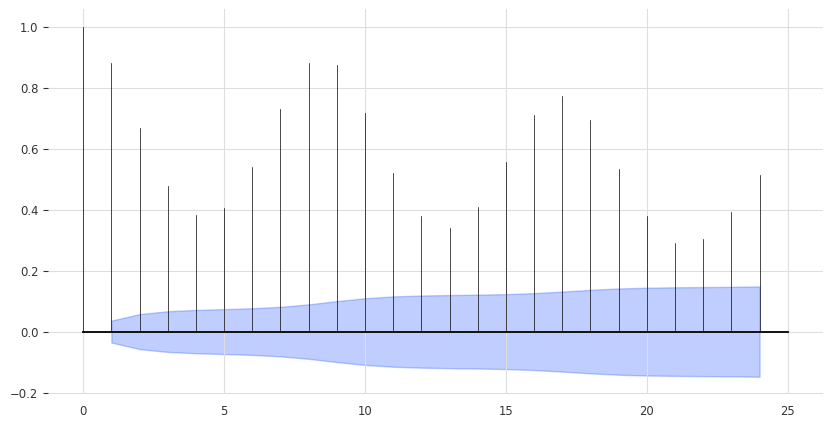

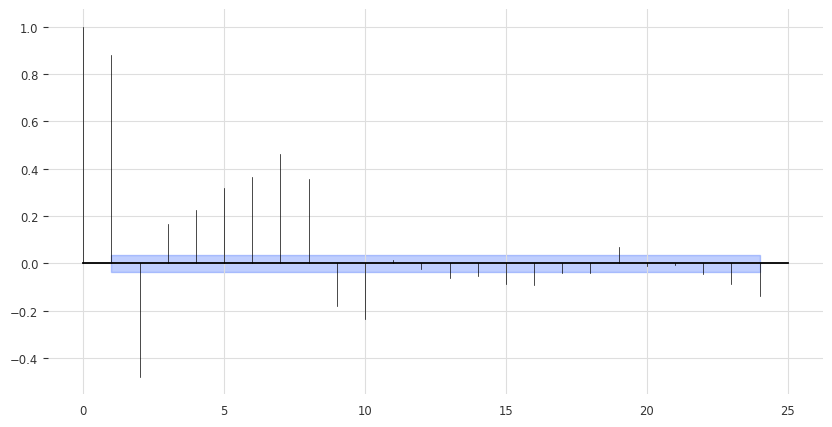

In [112]:
plot_acf(series_motor_cur)
plot_pacf(series_motor_cur)

### Graficas ACF y PACF series transformadas 

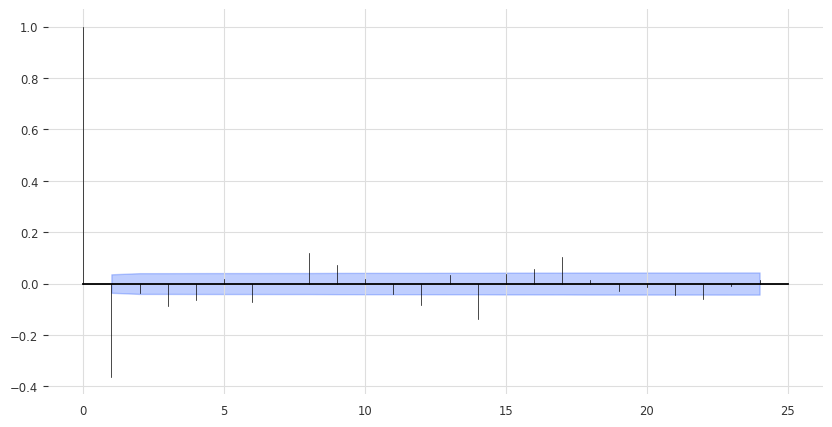

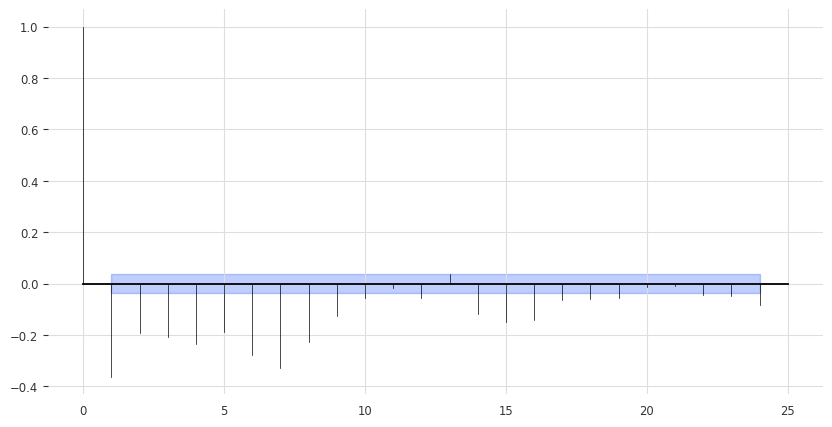

In [113]:
plot_acf(log_series_nut_temp_diff)
plot_pacf(log_series_nut_temp_diff)

In [116]:
## -------OJO REVISAR ESTO---

# plot_acf(log_series_motor_cur_diff)
# plot_pacf(log_series_motor_cur_diff)


In [117]:
import pmdarima as pm 

# Convierte la serie temporal de Darts a una serie de pandas
pd_nut_temp = log_series_nut_temp_diff.pd_series()

# Ajusta el modelo ARIMA utilizando auto_arima
auto_model = pm.auto_arima(pd_nut_temp, seasonal=False, stepwise=False,
                           suppress_warnings=True,
                           error_action="ignore",
                           max_order=None,
                           trace=True,
                           start_p =0 , max_p = 20,
                           start_q=0 , max_q=20)

# Obtén el AIC del modelo ajustado
aic_value_auto = auto_model.aic()
print(f'AIC auto modelo: {aic_value_auto}')

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-13722.576, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=1.49 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=1.57 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=1.64 sec
 ARIMA(0,0,6)(0,0,0)[0]             : AIC=inf, Time=2.33 sec
 ARIMA(0,0,7)(0,0,0)[0]             : AIC=-15438.393, Time=2.52 sec
 ARIMA(0,0,8)(0,0,0)[0]             : AIC=-15405.366, Time=2.90 sec
 ARIMA(0,0,9)(0,0,0)[0]             : AIC=-15449.573, Time=3.66 sec
 ARIMA(0,0,10)(0,0,0)[0]             : AIC=-15462.154, Time=4.21 sec
 ARIMA(0,0,11)(0,0,0)[0]             : AIC=inf, Time=5.53 sec
 ARIMA(0,0,12)(0,0,0)[0]             : AIC=-15533.665, Time=5.88 sec
 ARIMA(0,0,13)(0,0,0)[0]             : AIC=-15573.970, Time=7.13 sec
 ARIMA(0,0,14)(0,0,0)[0]             : AIC=-15506.573, Time=7.39 sec
 ARIMA(0,0,15)(0,0,0)[0]

In [118]:
# Obtén los parámetros estimados del modelo seleccionado

estimated_params = auto_model.arima_res_.params
print(f'Parámetros estimados: {estimated_params}')


Parámetros estimados: ar.L1    -0.252493
ar.L2    -0.781316
ar.L3    -0.873906
ar.L4    -0.804683
ar.L5    -1.269917
ar.L6    -1.340477
ar.L7    -0.976473
ar.L8    -0.785349
ar.L9    -0.685382
ar.L10   -0.489009
ar.L11   -0.579887
ar.L12   -0.288115
ar.L13   -0.101101
ma.L1    -0.670235
ma.L2     0.430176
ma.L3     0.048436
ma.L4    -0.078901
ma.L5     0.465439
ma.L6     0.024233
ma.L7    -0.346196
ma.L8    -0.170479
ma.L9    -0.119019
ma.L10   -0.129953
ma.L11    0.110624
ma.L12   -0.273224
ma.L13   -0.081646
ma.L14   -0.196805
ma.L15    0.102171
sigma2    0.000286
dtype: float64
